### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
import xgboost as xgb
import time
import joblib

pd.set_option('display.max_columns', None)

### Load data

In [2]:
tweets_df = pd.read_csv('..\data\stocks_merged.csv', index_col=0, parse_dates=['datetime'])

In [3]:
tweets_df.shape

(16327, 24)

In [4]:
tweets_df = tweets_df[tweets_df['stock'] == 'XOM']
tweets_df.shape

(3948, 24)

In [5]:
tweets_df.price_movement.value_counts(normalize=True)

1    0.575228
0    0.424772
Name: price_movement, dtype: float64

In [6]:
tweets_df.sample(3)

,datetime,text,username,likeCount,replyCount,retweetCount,stock,date_x,hour,minutes,dayofweek,predictiondate,price_movement,processed_text,tickers,number_tickers,hashtags,number_hashtags,mentions,number_mentions,text_length,lem_text,sentiment_label,sentiment_score
10096,2021-10-03 11:31:15-04:00,@Trendspider_J Happy Sunday Jake $XOM would be...,Outside_TheArc,1,0,0,XOM,2021-10-03,11,31,6,2021-10-04,1,@trendspiderj happy sunday jake $xom would be ...,['$xom'],1,[],0,['@trendspider_j'],1,88,@trendspiderj happy sunday jake $xom would be ...,positive,0.979433
9713,2021-12-11 11:48:00-05:00,"$XOM Perking up, broke the down trend this wee...",OptionsMike,3,0,0,XOM,2021-12-11,11,48,5,2021-12-13,0,$xom perking up broke the down trend this week...,['$xom'],1,[],0,[],0,81,$xom perking up broke the down trend this week...,neutral,0.620067
8501,2020-11-16 05:38:48-05:00,Same as $XOM: “Exxon needs another $8B to fund...,eddiedonmez,1,0,1,XOM,2020-11-16,5,38,0,2020-11-16,1,same as $xom “exxon needs another $b to fund d...,['$xom:'],1,[],0,['@chigrl'],1,168,same a $xom “exxon need another $b to fund div...,negative,0.503418


### Preprocessing

In [7]:
# Dropping some columns we will not use
tweets_df = tweets_df.drop(columns=['datetime','text','username','stock','date_x','predictiondate',\
                                   'processed_text','tickers','hashtags','mentions'])

In [8]:
# Mapping from number to day and cpnverting to category
tweets_df['dayofweek'] = tweets_df['dayofweek'].map({0:'M', 1:'Tu', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}).astype('category')

In [9]:
# One hot encoding for dayofweek and sentiment label 
tweets_df = pd.get_dummies(tweets_df, columns=['dayofweek','sentiment_label'], drop_first=True)
tweets_df.head(2)

,likeCount,replyCount,retweetCount,hour,minutes,price_movement,number_tickers,number_hashtags,number_mentions,text_length,lem_text,sentiment_score,dayofweek_M,dayofweek_Sa,dayofweek_Su,dayofweek_Th,dayofweek_Tu,dayofweek_W,sentiment_label_neutral,sentiment_label_positive
7876,1,0,1,23,28,0,1,0,0,64,$xom exxon mobil near yield and low valuation ...,0.645312,0,0,1,0,0,0,1,0
7877,1,1,1,11,26,0,1,1,0,242,two challenge for exxon’s operation in guyana ...,0.846923,0,0,1,0,0,0,1,0


In [10]:
X = tweets_df.drop(columns='price_movement')
y = tweets_df['price_movement']

In [11]:
X.shape, y.shape

((3948, 19), (3948,))

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
X_train.shape, X_test.shape

((2763, 19), (1185, 19))

In [14]:
# Resetting index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Scaling

In [15]:
minmax_scaler = MinMaxScaler()

In [16]:
X_train[['likeCount','replyCount','retweetCount','hour','minutes',\
                                     'number_tickers','number_hashtags','number_mentions','text_length']] = \
minmax_scaler.fit_transform(X_train[['likeCount','replyCount','retweetCount','hour','minutes',\
                                     'number_tickers','number_hashtags','number_mentions','text_length']])

In [17]:
X_test[['likeCount','replyCount','retweetCount','hour','minutes',\
                                     'number_tickers','number_hashtags','number_mentions','text_length']] = \
minmax_scaler.transform(X_test[['likeCount','replyCount','retweetCount','hour','minutes',\
                                     'number_tickers','number_hashtags','number_mentions','text_length']])

In [18]:
X_train.head(2)

,likeCount,replyCount,retweetCount,hour,minutes,number_tickers,number_hashtags,number_mentions,text_length,lem_text,sentiment_score,dayofweek_M,dayofweek_Sa,dayofweek_Su,dayofweek_Th,dayofweek_Tu,dayofweek_W,sentiment_label_neutral,sentiment_label_positive
0,0.023622,0.0,0.0,0.73913,0.644068,0.0,0.0,0.0,0.133333,exxon mobil $xom settled to $ soft target $s h...,0.800772,0,0,0,0,0,0,1,0
1,0.023622,0.0,0.0,1.00000,0.389831,0.0,0.0,0.0,0.594872,it also work well on bearish stock $xom bullbe...,0.518677,0,1,0,0,0,0,1,0


### Count Vectorizer

In [19]:
count_vectorizer = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,1))

In [20]:
#Vectorizing lem_text and converting to non-sparse array
train_vect = count_vectorizer.fit_transform(X_train['lem_text']).toarray()
test_vect = count_vectorizer.transform(X_test['lem_text']).toarray()

In [21]:
train_vect.shape, test_vect.shape

((2763, 578), (1185, 578))

In [22]:
# Creating a dataframe to join later with our dataframe
X_train_vect_df = pd.DataFrame(train_vect, columns=count_vectorizer.get_feature_names_out())
X_test_vect_df = pd.DataFrame(test_vect, columns=count_vectorizer.get_feature_names_out())

In [23]:
# Joining with our X train/test dataframes
X_train = X_train.join(X_train_vect_df, lsuffix='_t')
X_test = X_test.join(X_test_vect_df, lsuffix='_t')

In [24]:
# Saving lem_text before dropping
X_train_lem_text = X_train['lem_text']
X_test_lem_text = X_test['lem_text']

In [25]:
# Dropping lem_text
X_train = X_train.drop(columns='lem_text')
X_test = X_test.drop(columns='lem_text')

## Modeling

### Naive Bayes

In [26]:
param_nb = {'alpha':[.01, .1, 1, 10, 50] }

In [27]:
nb = MultinomialNB()
nb_clf = GridSearchCV(nb, param_nb, cv=5, scoring='roc_auc', n_jobs=-1)

In [28]:
start = time.time()
nb_model = nb_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Training time: 3 seconds


In [29]:
print(nb_model.best_params_)
print(nb_model.best_score_)

{'alpha': 0.01}
0.5819996002974347


### Naive Bayes - Tuned

In [30]:
nb_tuned = MultinomialNB(alpha=0.01)
nb_tuned.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [31]:
y_pred_nb = nb_tuned.predict(X_train)
y_pred_proba_nb = nb_tuned.predict_proba(X_train)[:,1]

In [32]:
print(classification_report(y_train, y_pred_nb))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59      1174
           1       0.70      0.78      0.74      1589

    accuracy                           0.68      2763
   macro avg       0.67      0.66      0.66      2763
weighted avg       0.68      0.68      0.68      2763



In [33]:
y_test_pred_nb = nb_tuned.predict(X_test)
y_test_pred_proba_nb = nb_tuned.predict_proba(X_test)[:,1]

In [34]:
print(classification_report(y_test, y_test_pred_nb))

              precision    recall  f1-score   support

           0       0.55      0.42      0.48       503
           1       0.64      0.74      0.69       682

    accuracy                           0.61      1185
   macro avg       0.59      0.58      0.58      1185
weighted avg       0.60      0.61      0.60      1185



### Random Forest

In [35]:
# Running grid search first for min_samples_leaf and split to get an idea of the range
param_rf = {'min_samples_leaf': [2, 5, 10],
           'min_samples_split': [2, 5, 10]}

In [36]:
rf = RandomForestClassifier(random_state=42)
rf_clf = RandomizedSearchCV(rf, param_distributions = param_rf, cv = 5, scoring = 'roc_auc', n_jobs = -1, random_state=42)

In [37]:
start = time.time()
rf_model = rf_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

C:\Users\jodur\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time: 6 seconds


In [38]:
print(rf_model.best_params_)
print(rf_model.best_score_)

{'min_samples_split': 2, 'min_samples_leaf': 2}
0.7279610307461233


Running a second round of tuning including more parameters.
<br>Some cells have been commented after train to prevent from running again since the model can take some minutes to train.

In [39]:
param_rf = {'n_estimators':[100, 300, 500],
            'max_depth':[5, 10, 30],
            'max_features':[0.3, 0.6, 1],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [2, 4, 6] }

In [40]:
rf_clf = RandomizedSearchCV(rf, param_distributions = param_rf, cv = 5, scoring = 'roc_auc', n_jobs = -1, random_state=42)

In [41]:
'''
start = time.time()
rf_model = rf_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')
'''

"\nstart = time.time()\nrf_model = rf_clf.fit(X_train, y_train)\nend = time.time()\nprint('Training time:', round(end - start,), 'seconds')\n"

In [42]:
'''
print(rf_model.best_params_)
print(rf_model.best_score_)
'''

'\nprint(rf_model.best_params_)\nprint(rf_model.best_score_)\n'

Training time: 60 seconds

{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.3, 'max_depth': 30}
<BR>0.7300968602231318


### RF - Tuned model

In [43]:

rf_tuned = RandomForestClassifier(n_estimators=300, min_samples_split = 4, min_samples_leaf = 4,\
                                  max_features= 0.3, max_depth=30)
rf_tuned.fit(X_train, y_train)


RandomForestClassifier(max_depth=30, max_features=0.3, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=300)

In [44]:
'''
# Save model
joblib.dump(rf_tuned, 'xom_rf_tuned.pkl')
'''

"\n# Save model\njoblib.dump(rf_tuned, 'xom_rf_tuned.pkl')\n"

In [45]:
# Load model
rf_tuned = joblib.load('xom_rf_tuned.pkl')
rf_tuned

RandomForestClassifier(max_depth=30, max_features=0.3, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=300)

In [46]:
y_pred_rf = rf_tuned.predict(X_train)
y_pred_proba_rf = rf_tuned.predict_proba(X_train)[:,1]

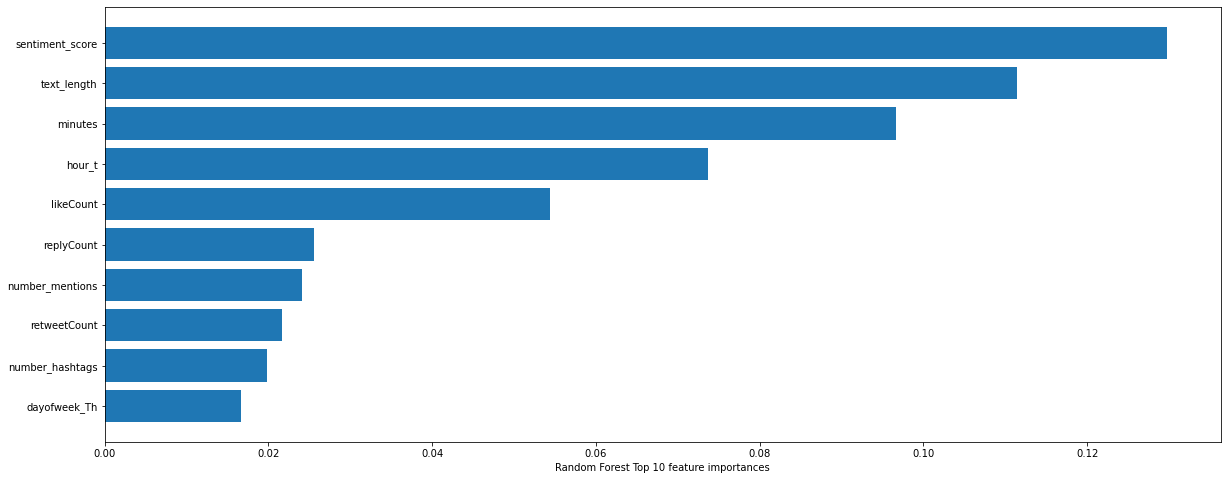

In [47]:
# Feature importances
plt.figure(figsize=(20,8))
sorted_idx = rf_tuned.feature_importances_.argsort()[-10:]
plt.barh(X_train.columns[sorted_idx], rf_tuned.feature_importances_[sorted_idx])
plt.xlabel('Random Forest Top 10 feature importances');

In [48]:
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1174
           1       0.90      1.00      0.95      1589

    accuracy                           0.94      2763
   macro avg       0.95      0.93      0.93      2763
weighted avg       0.94      0.94      0.94      2763



In [49]:
y_test_pred_rf = rf_tuned.predict(X_test)
y_test_pred_proba_rf = rf_tuned.predict_proba(X_test)[:,1]

In [50]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.74      0.39      0.51       503
           1       0.67      0.90      0.77       682

    accuracy                           0.68      1185
   macro avg       0.70      0.65      0.64      1185
weighted avg       0.70      0.68      0.66      1185



### XGBoost

The following code has been commented since it takes some time to run, we ran in Google Colab using GPUs. Also the same local version of XGBoost had to be installed in Colab to save the model.
<br>!pip install xgboost==1.6.2

In [51]:
'''
params_xg = {
            'n_estimators':[100, 150],
            'booster':['gbtree'],
            'colsample_bytree': [0.3, 0.6, 1],    #subsample ratio of columns when constructing each tree
            'max_depth': [2, 6, 10],
            'eta': [0.3]   #learning rate
            }
'''

"\nparams_xg = {\n            'n_estimators':[100, 150],\n            'booster':['gbtree'],\n            'colsample_bytree': [0.3, 0.6, 1],    #subsample ratio of columns when constructing each tree\n            'max_depth': [2, 6, 10],\n            'eta': [0.3]   #learning rate\n            }\n"

In [52]:
'''
#tree_method='gpu_hist' to use GPUs in Colab
xg = xgb.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist')
'''

"\n#tree_method='gpu_hist' to use GPUs in Colab\nxg = xgb.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist')\n"

In [53]:
'''
xg_clf = RandomizedSearchCV(xg, param_distributions=params_xg, scoring='roc_auc',\
                                   n_jobs=-1, cv=5, random_state=42)
'''

"\nxg_clf = RandomizedSearchCV(xg, param_distributions=params_xg, scoring='roc_auc',                                   n_jobs=-1, cv=5, random_state=42)\n"

In [54]:
'''
start = time.time()
xg_model = xg_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')
'''

"\nstart = time.time()\nxg_model = xg_clf.fit(X_train, y_train)\nend = time.time()\nprint('Training time:', round(end - start,), 'seconds')\n"

In [55]:
'''
print(xg_model.best_params_)
print(xg_model.best_score_)
'''

'\nprint(xg_model.best_params_)\nprint(xg_model.best_score_)\n'

Google Colab
<br>Training time: 43 seconds

{'n_estimators': 150, 'max_depth': 10, 'eta': 0.3, 'colsample_bytree': 0.6, 'booster': 'gbtree'}
<br>0.7443255296480219

### XGBoost - Tuned model

In [56]:
'''
xg_tuned = xgb.XGBClassifier(objective='binary:logistic', n_estimators=300, booster='gbtree', eval_metric='auc',\
                           colsample_bytree=0.6, max_depth=10, eta=0.3, random_state=42, tree_method='gpu_hist')
xg_tuned.fit(X_train, y_train)
'''

"\nxg_tuned = xgb.XGBClassifier(objective='binary:logistic', n_estimators=300, booster='gbtree', eval_metric='auc',                           colsample_bytree=0.6, max_depth=10, eta=0.3, random_state=42, tree_method='gpu_hist')\nxg_tuned.fit(X_train, y_train)\n"

In [57]:
'''
# save in JSON format
xg_tuned.save_model("xom_xg_tuned.json")
'''

'\n# save in JSON format\nxg_tuned.save_model("xom_xg_tuned.json")\n'

In [58]:
# Loading model

xg_tuned  = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, booster='gbtree', eval_metric='auc',\
                           colsample_bytree=0.6, max_depth=10, eta=0.3, random_state=42)

xg_tuned.load_model("xom_xg_tuned.json")

In [59]:
xg_tuned

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

In [60]:
y_pred_xg = xg_tuned.predict(X_train)
y_pred_proba_xg = xg_tuned.predict_proba(X_train)[:,1]

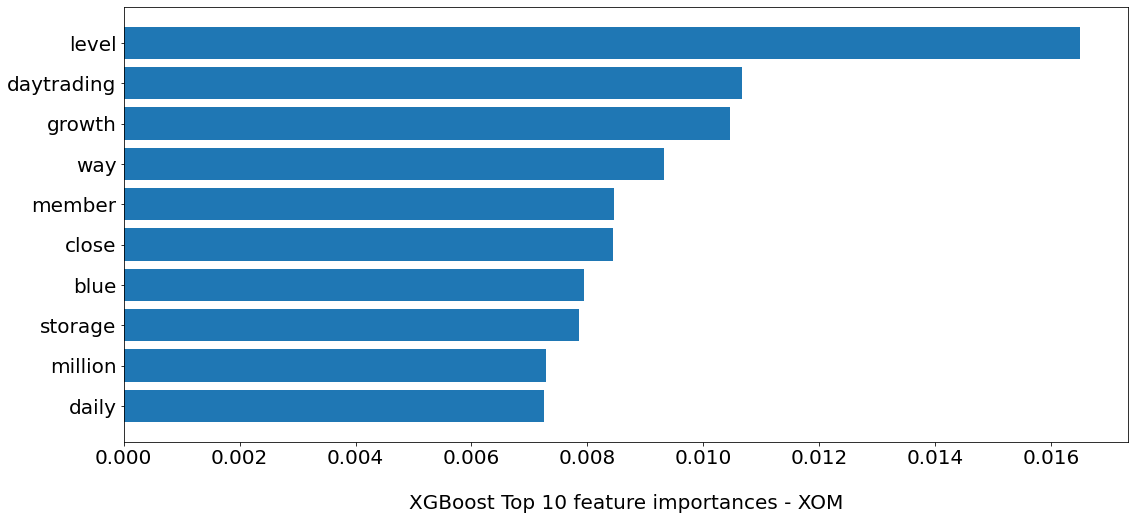

In [73]:
# Top 10 features
plt.figure(figsize=(18,8))
sorted_idx = xg_tuned.feature_importances_.argsort()[-10:]
plt.barh(X_train.columns[sorted_idx], xg_tuned.feature_importances_[sorted_idx])
plt.xlabel('\nXGBoost Top 10 feature importances - XOM', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [62]:
print(classification_report(y_train, y_pred_xg))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1174
           1       0.99      1.00      1.00      1589

    accuracy                           0.99      2763
   macro avg       1.00      0.99      0.99      2763
weighted avg       0.99      0.99      0.99      2763



In [63]:
y_test_pred_xg = xg_tuned.predict(X_test)
y_test_pred_proba_xg = xg_tuned.predict_proba(X_test)[:,1]

In [64]:
print(classification_report(y_test, y_test_pred_xg))

              precision    recall  f1-score   support

           0       0.70      0.58      0.64       503
           1       0.73      0.81      0.77       682

    accuracy                           0.72      1185
   macro avg       0.71      0.70      0.70      1185
weighted avg       0.71      0.72      0.71      1185



### 3 models AUC

Below are the AUC scores for the 3 models. We'll choose XGBoost and adjust the threshold for the predictions.

In [65]:
print(f'Naive Bayes AUC: \t {round(nb_model.best_score_,2)}')
print(f'Random Forest AUC: \t {round(rf_model.best_score_,2)}')
print(f'XGBoost AUC: \t\t 0.74')

Naive Bayes AUC: 	 0.58
Random Forest AUC: 	 0.73
XGBoost AUC: 		 0.74


### Threshold adjustment

Let's cycle thru different thresholds and capture precision and recall.

In [66]:
# Creating a dataframe to hold the values
df_thresholds = pd.DataFrame(columns=['Precision','Recall'])

for threshold in np.arange(0,1,0.01):
    y_temp = (y_pred_proba_xg > threshold).astype(int)
    df_thresholds.loc[threshold] = precision_score(y_train, y_temp), recall_score(y_train, y_temp)

Let's plot our precision and recall for different thresholds.

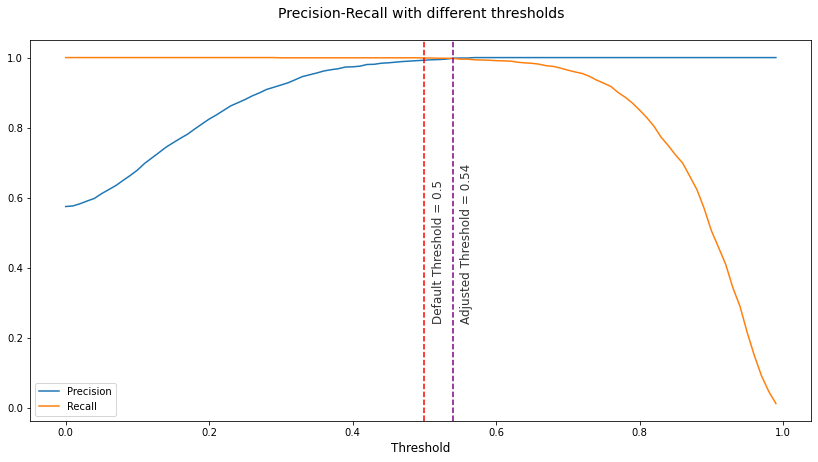

In [67]:
plt.figure(figsize=(14,7))
plt.plot(df_thresholds.index, df_thresholds['Precision'], label='Precision')
plt.plot(df_thresholds.index, df_thresholds['Recall'], label='Recall')
plt.axvline(0.5, color='red', linestyle='--')
plt.text(.51,.25,'Default Threshold = 0.5',rotation=90, alpha=0.8, fontsize=12)
plt.axvline(0.54, color='purple', linestyle='--')
plt.text(.55,.25,'Adjusted Threshold = 0.54',rotation=90, alpha=0.8, fontsize=12)
plt.xlabel('Threshold', fontsize=12)
plt.title('Precision-Recall with different thresholds\n', fontsize=14)
plt.legend();

### Final validation on our test set

We're setting the threshold to 0.54 and running a final validation on our test set.

In [68]:
y_test_pred = xg_tuned.predict(X_test)
y_test_pred_proba = xg_tuned.predict_proba(X_test)[:,1]

In [69]:
y_test_threshold = (y_test_pred_proba > 0.54).astype(int)

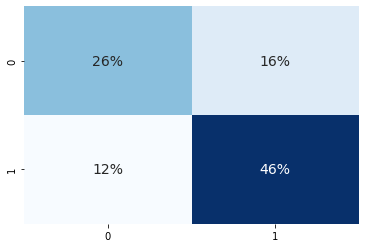

In [74]:
conf_matrix = confusion_matrix(y_test, y_test_threshold)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.0%', cmap='Blues', cbar=False, annot_kws={"fontsize":14});

In [71]:
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       503
           1       0.74      0.79      0.76       682

    accuracy                           0.72      1185
   macro avg       0.71      0.71      0.71      1185
weighted avg       0.72      0.72      0.72      1185

